In [1]:
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.10.0'

# Dataset
* 데이터셋 구성

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data, valid_data, train_labels, valid_labels = \
    train_test_split(train_data, train_labels, test_size=0.1, shuffle=True)

train_data = train_data / 255.
train_data = train_data.reshape(-1, 784)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

valid_data = valid_data / 255.
valid_data = valid_data.reshape(-1, 784)
valid_data = valid_data.astype(np.float32)
valid_labels = valid_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 784)
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)


* One-hot label 처리

In [3]:
def one_hot_label(image, label):
    label = tf.one_hot(label, depth=10)
    return image, label

In [4]:
batch_size = 32
max_epochs = 10

# for train
N = len(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for valid
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.repeat().batch(batch_size=batch_size)
print(valid_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


label = 6


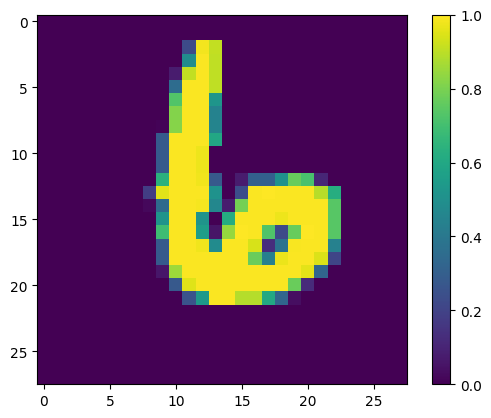

In [5]:
index = 1234
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

# 모델 제작

In [6]:
model = tf.keras.models.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
# Add another:
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [8]:
# without training, just inference a model in eager execution:
predictions = model(train_data[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[0.07559004 0.11153588 0.09598008 0.09646015 0.05903972 0.09116798
  0.11966117 0.11901299 0.1363539  0.09519816]]


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 256)                  200960    
                                                                 
 dropout (Dropout)           (1, 256)                  0         
                                                                 
 dense_1 (Dense)             (1, 128)                  32896     
                                                                 
 dense_2 (Dense)             (1, 64)                   8256      
                                                                 
 dense_3 (Dense)             (1, 10)                   650       
                                                                 
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


# Training

In [10]:
# using `numpy type` data
# history = model.fit(train_data, train_labels,
#                     batch_size=batch_size, epochs=max_epochs,
#                     validation_split=0.1)
# using `tf.data.Dataset` 
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=max_epochs,
                    validation_steps=len(valid_data) // batch_size,
                    steps_per_epoch=int(len(train_data) / batch_size))

Epoch 1/10
1687/1687 [==============================] - 5s 3ms/step - loss: 1.9923 - accuracy: 0.3523 - val_loss: 1.4150 - val_accuracy: 0.6857
Epoch 2/10
1687/1687 [==============================] - 4s 3ms/step - loss: 1.1780 - accuracy: 0.6809 - val_loss: 0.7414 - val_accuracy: 0.8138
Epoch 3/10
1687/1687 [==============================] - 4s 3ms/step - loss: 0.7833 - accuracy: 0.7732 - val_loss: 0.5340 - val_accuracy: 0.8638
Epoch 4/10
1687/1687 [==============================] - 4s 3ms/step - loss: 0.6220 - accuracy: 0.8175 - val_loss: 0.4408 - val_accuracy: 0.8820
Epoch 5/10
1687/1687 [==============================] - 4s 3ms/step - loss: 0.5363 - accuracy: 0.8412 - val_loss: 0.3901 - val_accuracy: 0.8914
Epoch 6/10
1687/1687 [==============================] - 4s 3ms/step - loss: 0.4843 - accuracy: 0.8569 - val_loss: 0.3545 - val_accuracy: 0.8987
Epoch 7/10
1687/1687 [==============================] - 4s 3ms/step - loss: 0.4435 - accuracy: 0.8700 - val_loss: 0.3291 - val_accuracy:

In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

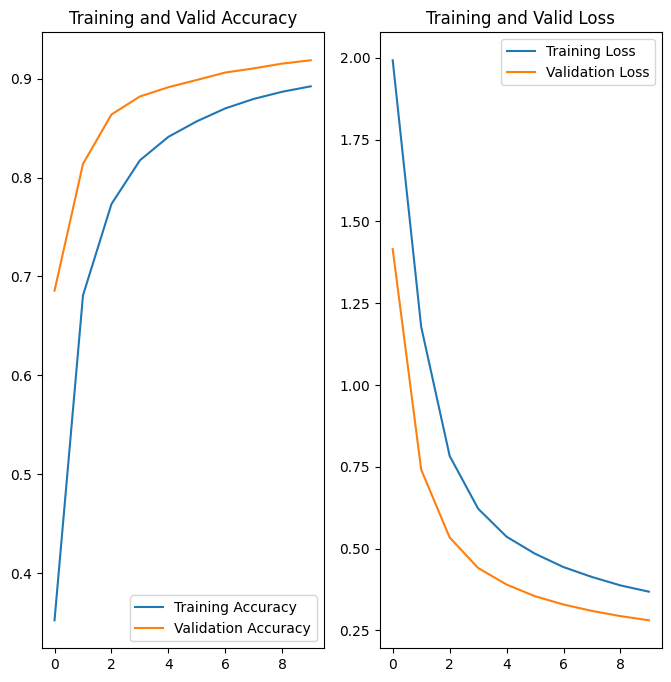

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

# Evaluation

In [13]:
results = model.evaluate(test_dataset)

313/313 [==============================] - 1s 2ms/step - loss: 0.2663 - accuracy: 0.9224


In [14]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1] * 100))

loss value: 0.266
accuracy value: 92.2400%


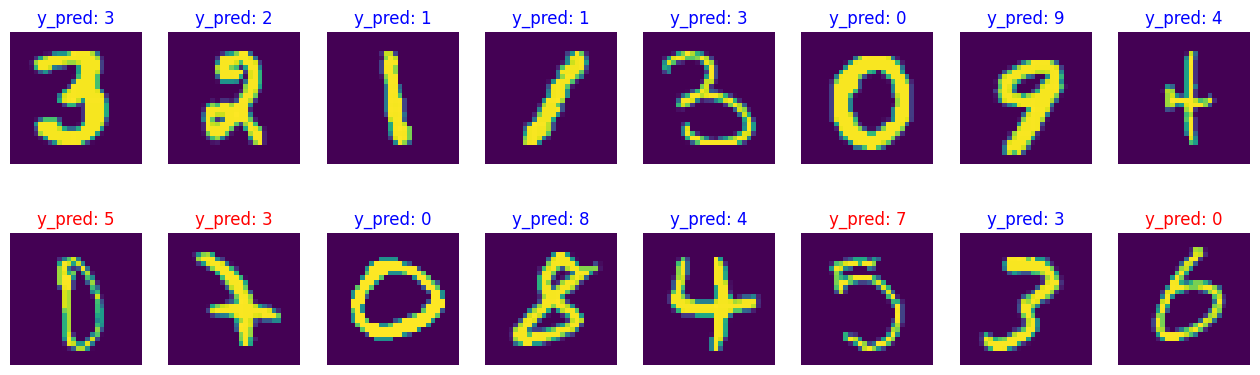

In [15]:
np.random.seed(219)
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
    p = fig.add_subplot(4, 8, i + 1)
    if np.argmax(py) == batch_ys[i]:
        p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
    else:
        p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
    p.imshow(px.reshape(28, 28))
    p.axis('off')